## 1. Setup

Use:
- PyTorch as deep learning framework
- PyTorch Lightning as a wrapper for PyTorch (something like Keras for Tensorflow)
- weights and biases library for MLOps https://wandb.ai/site
- custom logger for logging intermediate predictions on image samples 

In [2]:
# to be able to import scripts from ../src
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")
    
# pytorch utils
from pytorch_lightning import Trainer
from torchvision.utils import make_grid
import torch.nn as nn
import torchvision

# plotting
from utils import show

# weights and biases utils
from pytorch_lightning.loggers import WandbLogger
import wandb

# src scripts
from data_module import CIFAR10DataModule
from model import CIFAR10Model
from loggers import ImagePredictionLogger

In [2]:
wandb_logger = WandbLogger(project="f5611")

wandb: Currently logged in as: pkantek. Use `wandb login --relogin` to force relogin


## 2. Neural network

Use the MobileNetV3 neural architecture https://arxiv.org/abs/1905.02244, which is a CNN optimized for low-compute platforms but still being a decently strong model.

In [3]:
mobilenet = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V2, progress=True)
mobilenet.classifier[3] = nn.Linear(in_features=1280, out_features=10, bias=True)
mobilenet.train()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## 3. CIFAR-10 Dataset

The model will be trained on CIFAR-10 https://www.cs.toronto.edu/~kriz/cifar.html, which is a newer (and more sophisticated) alternative to MNIST. We also generate a list of sample images which will be sent to weights and biases report together with their predictions by the model.

In [3]:
transformations = [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.RandomAffine((10, 50)),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]

In [4]:
# setup data
cifar = CIFAR10DataModule(transformations)
cifar.prepare_data()
cifar.setup()

samples = next(iter(cifar.val_dataloader()))

Files already downloaded and verified
Files already downloaded and verified


Original images

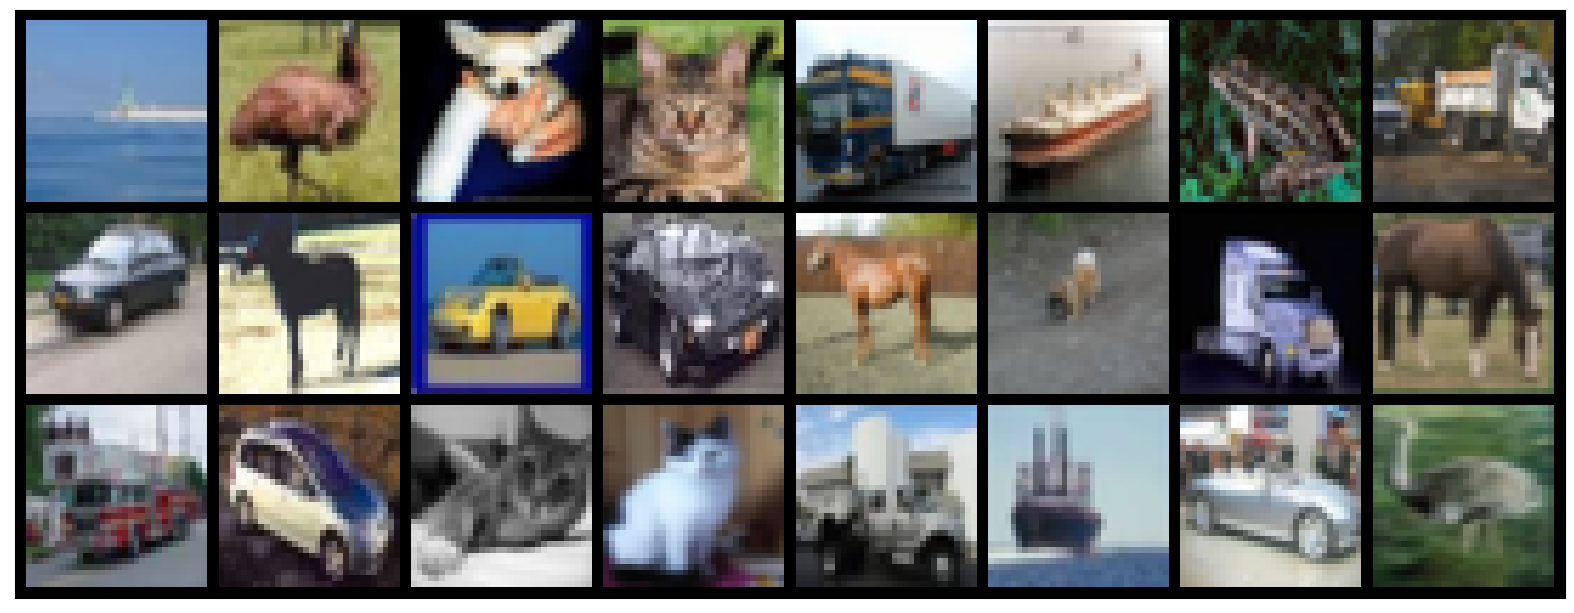

In [18]:
show(make_grid(samples[0][:24]))

Images with random affine transformations

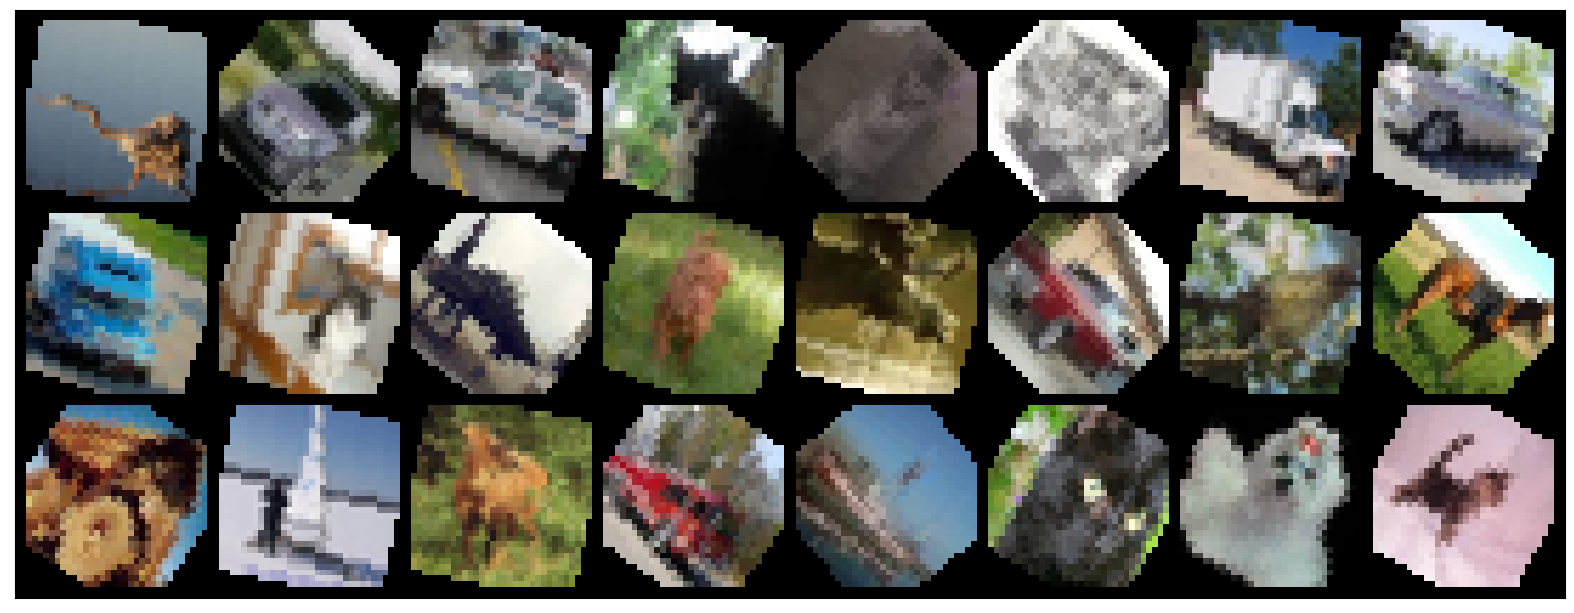

In [24]:
show(make_grid(samples[0][:24]))

Images with normalized pixels

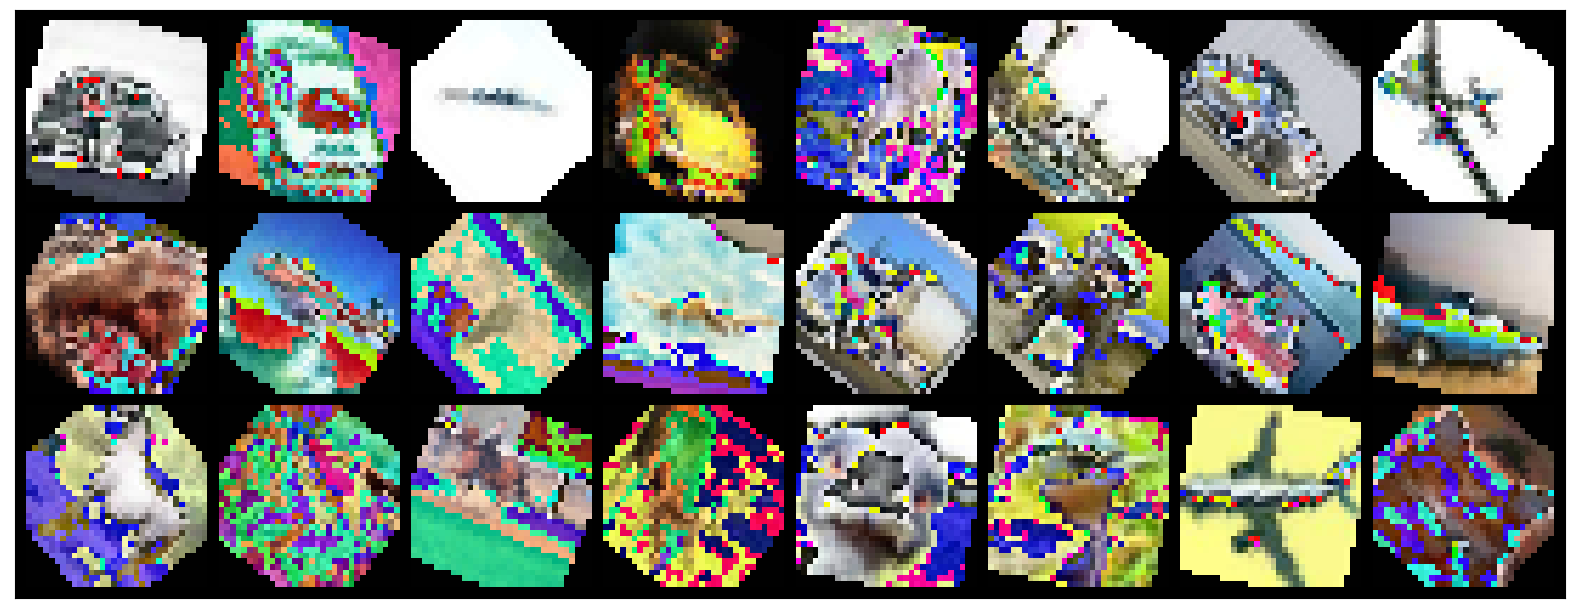

In [5]:
show(make_grid(samples[0][:24]))

## 4. Training

Training loop and metrics are logged using weights and biases library and a max. 5 epochs are run (because I don't have a GPU). 

In [5]:
trainer = Trainer(
    logger=wandb_logger,
    log_every_n_steps=50,   
    max_epochs=5,           
    deterministic=True,     
    callbacks=[ImagePredictionLogger(samples)]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
# setup model
model = CIFAR10Model(model=mobilenet, in_dims=(1, 3, 32, 32))

# fit the model
trainer.fit(model, cifar)

# evaluate the model on a test set
trainer.test(datamodule=cifar,
             ckpt_path=None)  # uses last-saved model

wandb.finish()

Files already downloaded and verified
Files already downloaded and verified



  | Name      | Type               | Params
-------------------------------------------------
0 | model     | MobileNetV3        | 4.2 M 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.859    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\pkantek\AppData\Local\pypoetry\Cache\virtualenvs\ml-astr-wIJ34D6o-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\pkantek\AppData\Local\pypoetry\Cache\virtualenvs\ml-astr-wIJ34D6o-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\pkantek\AppData\Local\pypoetry\Cache\virtualenvs\ml-astr-wIJ34D6o-py3.10\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
C:\Users\pkantek\AppData\Local\pypoetry\Cache\virtualenvs\ml-astr-wIJ34D6o-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at .\f5611\2i9tbh67\checkpoints\epoch=1-step=1408.ckpt
Loaded model weights from checkpoint at .\f5611\2i9tbh67\checkpoints\epoch=1-step=1408.ckpt
C:\Users\pkantek\AppData\Local\pypoetry\Cache\virtualenvs\ml-astr-wIJ34D6o-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/acc_epoch       │    0.6108999848365784     │
│      test/loss_epoch      │    1.1255593299865723     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████▅
global_step,▁▁▅▅██
test/acc_epoch,▁
test/loss_epoch,▁
train/acc_epoch,▁█
train/acc_step,▁▂▃▄▂▅▄▄▄▄▄▅▅▅█▅▆▅▆▆▇▆██▆▇█▇▇▇█▆▇
train/loss_epoch,█▁
train/loss_step,█▇▇▆▇▅▅▅▅▅▅▄▄▄▂▄▃▄▃▄▂▃▁▁▃▂▁▂▂▁▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
valid/acc_epoch,▁█
valid/loss_epoch,█▁


## 5. Hyperparameter tuning

Using the ray library, perform a parallel hyperparameter search for the best learning rate. 

In [10]:
import ray

# put the dataset into ray's object storage
cifar_ref = ray.put(cifar)

In [11]:
import ray

from ray import air, tune
from ray.tune.integration.pytorch_lightning import TuneReportCallback

from ray.air import session
from ray.air.integrations.wandb import WandbLoggerCallback


def train_model(config):
    model = CIFAR10Model(model=mobilenet, in_dims=(1, 3, 32, 32), lr=config["lr"])
    
    metrics = {"loss": "valid/loss_epoch", "acc": "valid/acc_epoch"}
    callbacks = [TuneReportCallback(metrics, on="validation_end")]

    trainer = Trainer(
        logger=wandb_logger,    
        log_every_n_steps=100,  
        max_epochs=5,          
        deterministic=True,    
        callbacks=callbacks, 
        enable_progress_bar=False
    )
    
    trainer.fit(model, ray.get(cifar_ref))


config = {
    "lr": tune.loguniform(1e-5, 1e-1)
}

tuner = tune.Tuner(
    train_model,
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        num_samples=8
    ),
    run_config=air.RunConfig(
        name="tune_cifar",
            # throws an error (probably a recet issue with ray and w&b)
            # callbacks=[
            #     WandbLoggerCallback(project="f5611")
            # ]
        ),
    param_space=config
)

results = tuner.fit()

2023-01-15 11:56:44,759	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (16 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(train_model pid=16996) GPU available: False, used: False
(train_model pid=16996) TPU available: False, using: 0 TPU cores
(train_model pid=16996) IPU available: False, using: 0 IPUs
(train_model pid=16996) HPU available: False, using: 0 HPUs


(train_model pid=16996) Files already downloaded and verified
(train_model pid=16996) Files already downloaded and verified


(train_model pid=16996) 
(train_model pid=16996)   | Name      | Type               | Params
(train_model pid=16996) -------------------------------------------------
(train_model pid=16996) 0 | model     | MobileNetV3        | 4.2 M 
(train_model pid=16996) 1 | train_acc | MulticlassAccuracy | 0     
(train_model pid=16996) 2 | valid_acc | MulticlassAccuracy | 0     
(train_model pid=16996) 3 | test_acc  | MulticlassAccuracy | 0     
(train_model pid=16996) -------------------------------------------------
(train_model pid=16996) 4.2 M     Trainable params
(train_model pid=16996) 0         Non-trainable params
(train_model pid=16996) 4.2 M     Total params
(train_model pid=16996) 16.859    Total estimated model params size (MB)
(train_model pid=16996) C:\Users\pkantek\AppData\Local\pypoetry\Cache\virtualenvs\ml-astr-wIJ34D6o-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many wor

(train_model pid=6772) Files already downloaded and verified


(train_model pid=3248) GPU available: False, used: False
(train_model pid=3248) TPU available: False, using: 0 TPU cores
(train_model pid=3248) IPU available: False, using: 0 IPUs
(train_model pid=3248) HPU available: False, using: 0 HPUs


(train_model pid=12768) Files already downloaded and verified
(train_model pid=3248) Files already downloaded and verified
(train_model pid=6772) Files already downloaded and verified
(train_model pid=12768) Files already downloaded and verified
(train_model pid=3248) Files already downloaded and verified


(train_model pid=6772) 
(train_model pid=6772)   | Name      | Type               | Params
(train_model pid=6772) -------------------------------------------------
(train_model pid=6772) 0 | model     | MobileNetV3        | 4.2 M 
(train_model pid=6772) 1 | train_acc | MulticlassAccuracy | 0     
(train_model pid=6772) 2 | valid_acc | MulticlassAccuracy | 0     
(train_model pid=6772) 3 | test_acc  | MulticlassAccuracy | 0     
(train_model pid=6772) -------------------------------------------------
(train_model pid=6772) 4.2 M     Trainable params
(train_model pid=6772) 0         Non-trainable params
(train_model pid=6772) 4.2 M     Total params
(train_model pid=6772) 16.859    Total estimated model params size (MB)
(train_model pid=6772) C:\Users\pkantek\AppData\Local\pypoetry\Cache\virtualenvs\ml-astr-wIJ34D6o-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which ma

Trial name,acc,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_4bb8d_00000,0.623,2023-01-15_12-57-09,True,,28551eaaf4914acd84627ca244c087da,0_lr=0.0052,CZW21I26Q1204,5,1.08385,127.0.0.1,16996,3619.9,699.474,3619.9,1673783829,0,,5,4bb8d_00000,0
train_model_4bb8d_00001,0.0982,2023-01-15_13-01-03,True,,c6571711bfae495f9dde9956facec392,1_lr=0.0277,CZW21I26Q1204,5,2.35855,127.0.0.1,6772,3847.4,711.435,3847.4,1673784063,0,,5,4bb8d_00001,0.00299931
train_model_4bb8d_00002,0.09,2023-01-15_13-01-06,True,,b489e2df2f8d4f06872eb3690bb37e01,2_lr=0.0688,CZW21I26Q1204,5,2.31379,127.0.0.1,12768,3850.99,711.809,3850.99,1673784066,0,,5,4bb8d_00002,0.00499988
train_model_4bb8d_00003,0.7638,2023-01-15_12-53-13,True,,e6c561fcefc74cd197f847112da816b8,3_lr=0.0005,CZW21I26Q1204,5,0.840888,127.0.0.1,3248,3376.87,632.425,3376.87,1673783593,0,,5,4bb8d_00003,0.00399852


(train_model pid=3248) `Trainer.fit` stopped: `max_epochs=5` reached.
(train_model pid=16996) `Trainer.fit` stopped: `max_epochs=5` reached.
(train_model pid=6772) `Trainer.fit` stopped: `max_epochs=5` reached.
(train_model pid=12768) `Trainer.fit` stopped: `max_epochs=5` reached.
2023-01-15 13:01:08,035	INFO tune.py:762 -- Total run time: 3865.49 seconds (3865.08 seconds for the tuning loop).


Best hyperparameters found were:  {'lr': 0.0005211356069429316}


In [16]:
results.get_dataframe()

,loss,acc,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/lr,logdir
0,1.083846,0.6230,699.474198,False,NaN,NaN,5,4bb8d_00000,28551eaaf4914acd84627ca244c087da,2023-01-15_12-57-09,...,3619.897151,16996,CZW21I26Q1204,127.0.0.1,3619.897151,0,5,0.000000,0.005161,C:\Users\pkantek\ray_results\tune_cifar\train_...
1,2.358554,0.0982,711.434555,False,NaN,NaN,5,4bb8d_00001,c6571711bfae495f9dde9956facec392,2023-01-15_13-01-03,...,3847.400492,6772,CZW21I26Q1204,127.0.0.1,3847.400492,0,5,0.002999,0.027726,C:\Users\pkantek\ray_results\tune_cifar\train_...
2,2.313794,0.0900,711.809440,False,NaN,NaN,5,4bb8d_00002,b489e2df2f8d4f06872eb3690bb37e01,2023-01-15_13-01-06,...,3850.991401,12768,CZW21I26Q1204,127.0.0.1,3850.991401,0,5,0.005000,0.068803,C:\Users\pkantek\ray_results\tune_cifar\train_...
3,0.840888,0.7638,632.424868,False,NaN,NaN,5,4bb8d_00003,e6c561fcefc74cd197f847112da816b8,2023-01-15_12-53-13,...,3376.872896,3248,CZW21I26Q1204,127.0.0.1,3376.872896,0,5,0.003999,0.000521,C:\Users\pkantek\ray_results\tune_cifar\train_...
